# Extended Cox model (recurrent events, time varying features)

In this notebook I implemented the pipeline for the fitting of the realizations of the compensator of the counting process about the hospitalisations.

The data comes from patients affected by heart disease in a follow-up interval of one year from the exit-time of the first hospitalization. 

The following steps are made:

1. Model choice
2. Model fitting
3. Smoothing of baseline Hazard
4. Reconstruction of the patient-specific cumulative Hazards
5. Check of Martingale residuals

In [1]:
require(data.table)
require(ggplot2)
require(survival)
library(cobs)     # Package for constrained L1 B-splines

options(repr.plot.width=6, repr.plot.height=4)

Loading required package: data.table
Loading required package: ggplot2
Loading required package: survival


In [2]:
path = '/Users/davide/Documents/universita/tesi/src/fit_compensators/'
setwd(path)
source('compute_cumulative_hazards.R')
load('../../data/preprocessed_data_aldosteronics.RData')

sel_df = aldosteronics_df

In [3]:
# preprocessed data
tail(sel_df, n = 8)

id,start,stop,status,sex,age_in,Nm,y
23393275,107.0,156.0,1,F,64,4,180
23393275,156.0,205.0,1,F,64,5,240
23393275,205.0,273.0,1,F,64,6,300
23393275,273.0,300.0,1,F,64,7,340
23393275,300.0,322.0,1,F,64,8,380
23393275,322.0,365.5,0,F,64,9,420
23405479,-0.5,39.0,1,M,64,0,0
23405479,39.0,365.5,0,M,64,1,27


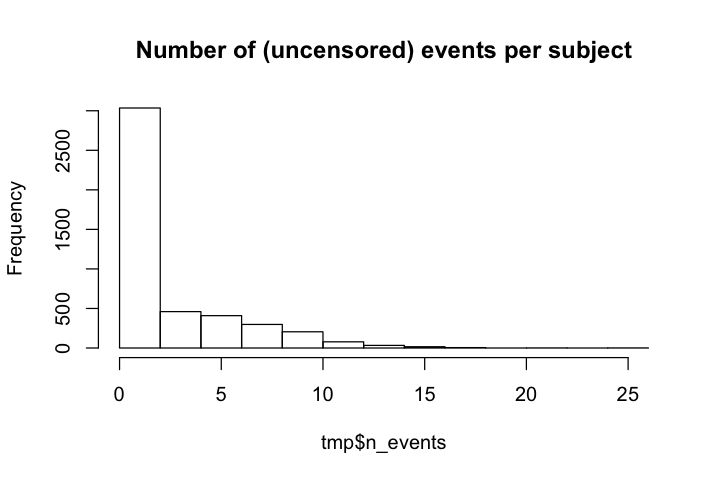

In [4]:
tmp = sel_df[,list('n_events' = max(Nm)),by = 'id']
hist(tmp$n_events, main = 'Number of (uncensored) events per subject')

# Model Choice

## Evaluate goodness of fit 

In [15]:
set.seed(123)
#Randomly shuffle the patients
patients = sample(unique(sel_df$id))
#Create 10 equally size folds
folds <- cut(seq(1,length(patients)),breaks=10,labels=FALSE)

#Perform 10 fold cross validation
scores = NULL
pb <- txtProgressBar(min = 0, max = 10, style = 3)
for(i in 1:10){
    setTxtProgressBar(pb, i)
    #Segement patients by fold 
    validIndexes <- which(folds==i,arr.ind=TRUE)
    valid_patients <- patients[validIndexes]
    train_patients <- patients[-validIndexes]
    # Split train, valid
    train = sel_df[id %in% train_patients]
    valid = sel_df[id %in% valid_patients]
    
    # fit
    models = list(
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + y + Nm:y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + y + Nm:y + cluster(id), data = train),
        
        # log(Nm+1)
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + y + log(Nm+1):y + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + y + log(Nm+1):y + cluster(id), data = train),
        
        # log(y+1)
        coxph(Surv(start,stop,status)~ age_in + sex + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(y+1) + Nm:log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + Nm + log(y+1) + Nm:log(y+1) + cluster(id), data = train),
        
        # log(Nm+1), log(y+1)
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(y+1) + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ age_in + sex + log(Nm+1) + log(y+1) + log(Nm+1):log(y+1) + cluster(id), data = train),
        coxph(Surv(start,stop,status)~ sex + log(Nm+1) + log(y+1) + log(Nm+1):log(y+1) + cluster(id), data = train)
    )
    # predict, evaluate
    fold_scores = c()
    for(model in models){
        # evaluate martingale residuals at validation events
        valid_model = coxph(model$formula,data = valid, init = model$coefficients, iter.max = 0)
        res = residuals(valid_model, type = "martingale")
        score = mean(abs(res)) # mean absolute residual 
        fold_scores = c(fold_scores,score)
    }
    scores = rbind(scores,fold_scores)
}
rownames(scores) = 1:10
colnames(scores) = names(models)

  |======================================================================| 100%

In [16]:
# summarize CV scores
mean_scores = colMeans(scores)
best_score = min(mean_scores)
worst_score = max(mean_scores)

In [17]:
# print cv scores
print('****************** Cross validation mean absolute Martingale residual ******************')
cat('\n')
print('|------------------------|--------------------------------------|')
print('|   MEAN ABS. RESIDUAL   |               FORMULA                |')
print('|------------------------|--------------------------------------|')
for(i in 1:length(models)){
    score = mean_scores[i]
    if(score != best_score & score != worst_score){
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3]))
    }else if (score == best_score){
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3], '                 <------ BEST MODEL'))
    }else{
        print(paste('|       ',round(mean_scores[i],3),'          | ',models[[i]]$formula[3], '                 <------ WORST MODEL'))
    }
}

[1] "****************** Cross validation mean absolute Martingale residual ******************"

[1] "|------------------------|--------------------------------------|"
[1] "|   MEAN ABS. RESIDUAL   |               FORMULA                |"
[1] "|------------------------|--------------------------------------|"
[1] "|        0.754           |  age_in + sex + Nm + cluster(id)"
[1] "|        0.835           |  age_in + sex + y + cluster(id)"
[1] "|        0.754           |  age_in + sex + Nm + y + cluster(id)"
[1] "|        0.927           |  age_in + sex + Nm:y + cluster(id)                  <------ WORST MODEL"
[1] "|        0.722           |  age_in + sex + Nm + Nm:y + cluster(id)"
[1] "|        0.827           |  age_in + sex + y + Nm:y + cluster(id)"
[1] "|        0.668           |  age_in + sex + Nm + y + Nm:y + cluster(id)"
[1] "|        0.627           |  age_in + sex + log(Nm + 1) + cluster(id)"
[1] "|        0.628           |  age_in + sex + log(Nm + 1) + y + cluster(id)"
[1] "|

# Fit model

In [18]:
# in order to use some function in the following cells, we build features corresponding to the transformed variables
sel_df[,'sexM':= ifelse(sex == 'M',1,0)]
sel_df[,'logp1_Nm':= log(Nm+1)]
sel_df[,'logp1_y':= log(y+1)]
sel_df[,'logp1_Nm_times_logp1_y':= log(Nm+1)*log(y+1)]

In [19]:
model = coxph(Surv(start,stop,status)~  sex + logp1_Nm + logp1_y + logp1_Nm_times_logp1_y + cluster(id) ,data = sel_df)
model

Call:
coxph(formula = Surv(start, stop, status) ~ sex + logp1_Nm + 
    logp1_y + logp1_Nm_times_logp1_y + cluster(id), data = sel_df)

                           coef exp(coef) se(coef) robust se       z       p
sexM                   -0.05818   0.94348  0.01960   0.01996  -2.914 0.00356
logp1_Nm                2.29032   9.87814  0.06647   0.07001  32.715 < 2e-16
logp1_y                 0.18427   1.20234  0.01298   0.01294  14.235 < 2e-16
logp1_Nm_times_logp1_y -0.25107   0.77797  0.01183   0.01454 -17.273 < 2e-16

Likelihood ratio test=11368  on 4 df, p=< 2.2e-16
n= 14977, number of events= 10436 

# Compute and smooth baseline Hazards

In [20]:
# get baseline
bh = basehaz(model, centered = FALSE)

t <- bh$time
Lambda0 <- bh$hazard

In [21]:
# Smooth version of Lambda0
Lambda0S <- cobs(t,Lambda0,constraint=c("increase"),pointwise=matrix(c(0,-0.5,0),nrow=1),nknots=20,lambda=0,toler.kn=0)

qbsks2():
 Performing general knot selection ...

 Deleting unnecessary knots ...


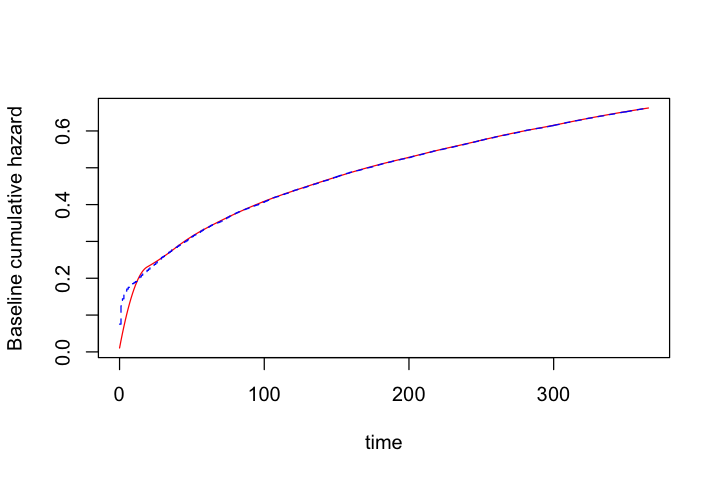

In [22]:
# Comparison between basic and smooth estimate
plot(Lambda0S$x,Lambda0S$fitted,type="l",main="",ylab="Baseline cumulative hazard",xlab="time", col = 'red')
points(t,Lambda0,type="s",lty=2, col = 'blue')

# Reconstruct patients cumulative Hazards

In [23]:
# We evaluate cumulative hazards in a grid of days 
times <- seq(0,365,by=1)
cumulative_hazard = compute_cumulative_hazard(model,sel_df,Lambda0S,times,verbose = TRUE)

[1] "Computing coefficients ck"
  |======================================================================| 100%
[1] "Computing cumulative Hazard on the grid"
  |======================================================================| 100%


In [24]:
head(cumulative_hazard)

id,time,cumhaz
10000243,0,0.009984908
10000243,1,0.029258556
10000243,2,0.047603979
10000243,3,0.065021177
10000243,4,0.081510150
10000243,5,0.097070899


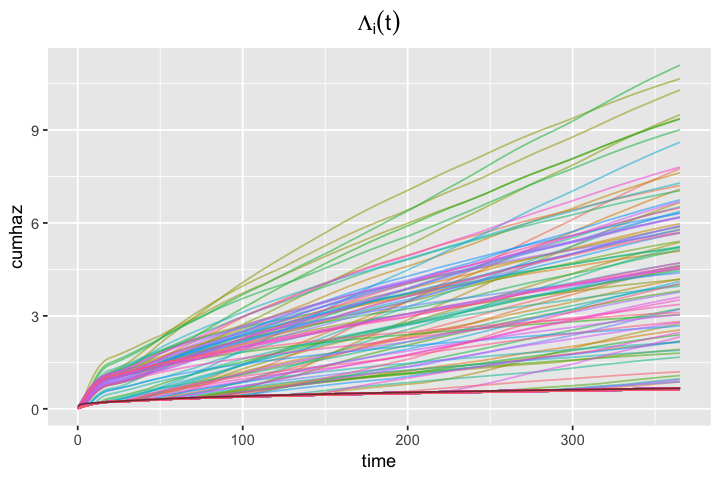

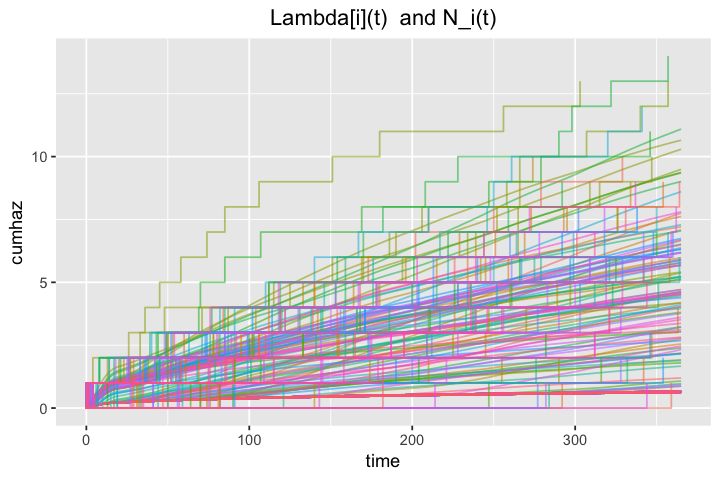

In [25]:
# select a sample to plot
sample_patients = sample(unique(sel_df$id),200)
sample = cumulative_hazard[cumulative_hazard$id %in% sample_patients,]
sample_N = sel_df[id %in% sample_patients,]
bh['id'] = 0

# plot
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_line(data = bh, aes(x= time, y=hazard), color = 'black') +
    ggtitle(expression(Lambda[i](t))) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

# plot also realization
ggplot(sample, aes(x= time, y=cumhaz, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line() +
    geom_step(data = sample_N, aes(x= start, y=Nm,group = factor(id), color=factor(id))) +
    ggtitle(paste(expression(Lambda[i](t)),' and N_i(t)')) +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))

In [26]:
# save
save(cumulative_hazard, file = '../../data/cumulative_hazards_aldosteronics.RData')

In [27]:
load('../../data/cumulative_hazards_aldosteronics.RData')

# Check Martingale residuals

In [28]:
# compute dataset of daily realizations (only once)
source('compute_daily_realizations.R')
daily_realizations_aldosteronics = compute_daily_realizations(sel_df)
save(daily_realizations_aldosteronics, file = '../../data/daily_realizations_aldosteronics.RData')

  |======================================================================| 100%


In [29]:
# load dataset of daily realizations 
load('../../data/daily_realizations_aldosteronics.RData')
daily_realizations = daily_realizations_aldosteronics

In [30]:
# compute residuals
residuals = cbind(cumulative_hazard, Nt = daily_realizations$Nt)
residuals['residuals'] = residuals$cumhaz - residuals$Nt
residuals = data.table(residuals)

# compute mean residuals
mean_residuals = residuals[,list('residuals' = mean(residuals)), by = 'time']

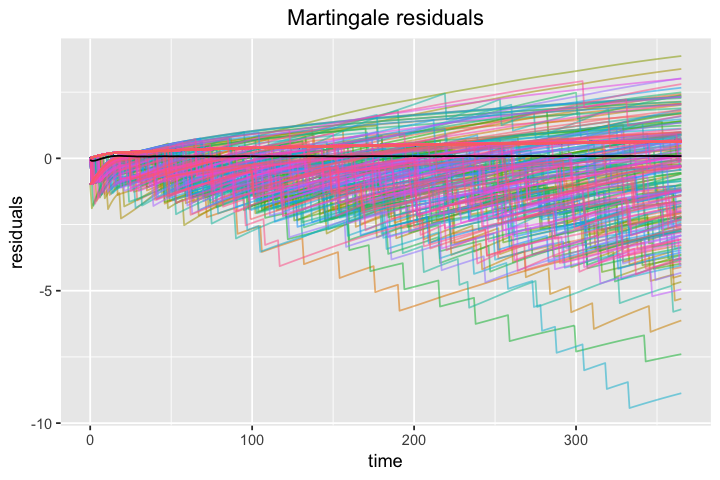

In [31]:
# select sample of patients to plot
sample_patients = sample(unique(sel_df$id),500)
sample = residuals[id %in% sample_patients,]

# plot
ggplot(data = mean_residuals, aes(x= time, y=residuals)) +
    geom_line() +
    geom_line(data = sample, aes(x= time, y=residuals, group = factor(id), color=factor(id),alpha = 0.1)) +
    geom_line(data = mean_residuals, aes(x= time, y=residuals)) +
    ggtitle('Martingale residuals') +
    theme(legend.position="none",plot.title = element_text(hjust = 0.5))